In [ ]:
# After the checks in notebook 3.Trig_Coin_test_with_injection.ipynb
# are successful, we can run the triggering and coincidence
# in bulk on the LVK strain data files from a full observing run.
# This notebook is used for running triggering and coincidence 
# on a HPC cluster.

# Check the google drive folder for the latest version of this and other notebooks:
# https://drive.google.com/drive/folders/15avuKxY40aX9Ru_6xkacM1ZdaGL7OgQm?usp=sharing

In [3]:
import os, sys
from pathlib import Path
sys.path.insert(0,os.path.join(Path(os.getcwd()).parent, 'Pipeline'))
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # personalize path if needed
import utils

In [4]:
# By default, we will use the data files from the following directory

utils.STRAIN_ROOT['O3a']

# Instructions for downloading the LVK data,
# are in section 0 in notebook 3.Trig_Coin_test_with_injection.ipynb

'/Users/jayw/Documents/Acad/GW/Pipeline_data/LVK_strain_data/O3a'

# 1. Triggering on cluster

## 1.1 Checking individual files

In [ ]:
# Checking if individual files run properly before
# sending the bulk jobs in the subsection below

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import utils
import template_bank_params_O3a_HM as tbp

# The main file associated with this notebook is triggering_on_cluster.py
import triggering_on_cluster

In [31]:
ib = 14
isb = 0
run='O3a'
det_names = ['H1', 'L1']

ncores = 1 # Each core runs a different file

In [32]:
# Set the output path where you want to save the triggering files
output_dir = os.path.join(utils.DATA_ROOT, 'Testing')
# output_path = '/data/jayw/IAS/GW/Trash/Delete/Triggers_single_det'
bank_ids = tuple(f'BBH_{i}' for i in range(ib,ib+1)[::-1])
bank_subbank_dirs = [
    [os.path.join(output_dir, i+f'_bank_{isb}')]
    for i in bank_ids]
print(bank_subbank_dirs)

# Create the directories if they don't exist
for bank_dir in bank_subbank_dirs:
    for subbank_dir in bank_dir:
        os.makedirs(subbank_dir, exist_ok=True)

[['/Users/jayw/Documents/Acad/GW/Pipeline_data/Testing/BBH_14_bank_0']]


In [ ]:
cluster = "typhon"

# We need to specify name of the cluster to use
# (could just use cluster='typhon' by default)

# If you instead want to specify a different cluster
# add a separate function similar to submit_files_typhon()
# in triggering_on_cluster.py
# the main parameters to edit would be n_hours_limit and mem_per_cpu

In [33]:
# Let us choose specific data files to run on, e.g., 1246846976
data_epochs = [1246846976]
data_fnames = []
for epoch in data_epochs:
    for det in det_names:
        data_fnames.append(os.path.join(utils.STRAIN_ROOT[run.lower()],
            det, f"{det[0]}-{det}_GWOSC_O3a_4KHZ_R1-{epoch}-4096.hdf5"))

print(data_fnames)

['/Users/jayw/Documents/Acad/GW/Pipeline_data/LVK_strain_data/O3a/H1/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096.hdf5', '/Users/jayw/Documents/Acad/GW/Pipeline_data/LVK_strain_data/O3a/L1/L-L1_GWOSC_O3a_4KHZ_R1-1246846976-4096.hdf5']


In [36]:
# If submit is False, it gives you the slurm submission script
# If submit=True, it automatically sends the script to the cluster
# so, one would need to run it by logging onto the cluster

_ = triggering_on_cluster.submit_multibanks(
    tbp,
    files_to_submit=data_fnames, 
    use_HM=True, 
    bank_ids=bank_ids,
    cluster=cluster, 
    output_dirs=bank_subbank_dirs,
    njobchunks=1,
    fmax=512,
    n_cores=1,
    mem_per_cpu=6,
    n_hours_limit=24,
    submit=False)

#!/bin/bash 
#SBATCH --job-name=BBH_14
#SBATCH --output=/Users/jayw/Documents/Acad/GW/Pipeline_data/Testing/BBH_14_bank_0/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096.out
#SBATCH --open-mode=append
#SBATCH --nodes=1
#SBATCH --cpus-per-task=1
#SBATCH --time=24:00:00
#SBATCH --mem-per-cpu=6G
srun python /Users/jayw/Documents/Acad/GW/Public_pipeline/Pipeline/gw_detect_file.py /Users/jayw/Documents/Acad/GW/Pipeline_data/LVK_strain_data/O3a/H1/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096.hdf5 /Users/jayw/Documents/Acad/GW/Pipeline_data/Testing/BBH_14_bank_0/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096.npz /Users/jayw/Documents/Acad/GW/Pipeline_data/templates/O3_hm/Multibanks/BBH_14/bank_0/metadata.json /Users/jayw/Documents/Acad/GW/Pipeline_data/Testing/BBH_14_bank_0/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096.trig.npy /Users/jayw/Documents/Acad/GW/Pipeline_data/Testing/BBH_14_bank_0/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096_config.json --delta_calpha=0.3 --template_safety=1.05 --threshold_chi2=20 --base_threshold_c

In [ ]:
# An example of useful command for checking the details of 
# a particular running job:
# scontrol show jobid 6119076

In [25]:
# For inspecting the completion status of the files
isb = 0

dname = os.path.join(output_dir, f'BBH_{ib}_bank_{isb}')
status = triggering_on_cluster.inspect_completion(data_fnames, dname);

Reporting run statistics for 2 files
Divided bank into 1 chunks for generating triggers
Didn't start preprocessing for 0 files
Only finished preprocessing for 0 files
Partially generated triggers for 0 files
Failed on 0 files
Couldn't determine fate for 0 files
Finished generating triggers for 2 files


## 1.2. Running all files on cluster

In [ ]:
# Maybe run the bulk submission commands on a terminal on
# a login-node of your cluster,
# otherwise the outputs from submitting thousands of jobs
# can sometimes overload the juptyer notebook.
# The cells for checking the file status can be run in the notebook.

# Optional suggestion: First run the full search for one particular bank with few templates
# and run notebook 5.Ranking_candidates.ipynb to check if 
# the candidates, background and IFAR look sensible.

In [6]:
ib = 7
run='O3a'

# We are running one bank at a time
bank_ids = tuple(f'BBH_{i}' for i in range(ib,ib+1)[::-1])

# Set fmax (Hz). 
# This depends on the highest frequency in the waveforms in the bank
# In the case of arXiv:2310.15233, we use 1024 Hz for BBH-0 and BBH-1, 512 Hz for rest

if ib > 1:
    fmax=512 # Hz
    njobchunks=1
elif ib == 1:
    fmax=1024
    njobchunks=2
elif ib == 0:
    fmax=1024
    njobchunks=8

cluster = "typhon"

import os, sys
# Explicitly specify the path to your pipeline folder
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias")

import numpy as np
import triggering_on_cluster
import template_bank_params_O3a_HM as tbp
import utils

trig_dir = utils.TRIG_DIR[f'hm_{run}'.lower()]
print(f'''The triggers will be saved in this path:
{trig_dir}''')
detectors = ['H1', 'L1']

data_fnames = []
[data_fnames.extend(triggering_on_cluster.get_strain_filelist(run, det))
              for det in detectors];

print('We can run on:')
for det in ['H1', 'L1']:
    print(f'{len(triggering_on_cluster.get_strain_filelist(run, det))} files in {det}')

bank_subbank_dirs = [
    [os.path.join(trig_dir, i+f'_bank_{j}') for j in range(tbp.nsubbanks[i])]
    for i in bank_ids]

# Create the directories if they don't exist
for bank_dir in bank_subbank_dirs:
    for subbank_dir in bank_dir:
        os.makedirs(subbank_dir, exist_ok=True)

The triggers will be saved in this path:
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Triggers_single_det
We can run on:
5 files in H1
5 files in L1


In [42]:
# Typhon 1st pass
# STATUS: O3a: all banks done (I just write the status here, e.g., banks 14-16 done)

# If you want to test the code on a few files before running on all of them
# set test_few to e.g.,1. Otherwise use test_few=None
# You can manually also run the command from the script below in the terminal
# python ..../gw_detect_file.py ...
test_few = None

# If submit is False, it gives you the slurm submission script
# If submit=True, it automatically sends the script to the cluster
# so, one would need to run it by logging onto the cluster
submit = False

mem_per_cpu = 6 # 6GB for first pass, then increase to 16-40GB

_ = triggering_on_cluster.submit_multibanks(
    tbp, files_to_submit=data_fnames, use_HM=True, bank_ids=bank_ids,
    cluster=cluster, output_dirs=bank_subbank_dirs, n_cores=1,
    njobchunks=njobchunks, # Different for different banks (specified above)
    mem_per_cpu=mem_per_cpu, # 6GB for first pass, then increase to 16-40GB
    fmax=fmax, # Different for different banks (specified above)
    exclude_nodes=False, # Set true if other ppl complain about cluster use (excludes some nodes)
    test_few=test_few,
    submit=submit
    )

We have 297 templates in the bank,
        so will use threshold_chi2 before and after sinc-interp 
        as 19 and 22 respectively.
We will use the following subbanks: [0, 1]
Running for 0 files in subbank 0 of bank BBH_7
Running for 0 files in subbank 1 of bank BBH_7


### Inspecting completion and rerunning failed files

In [ ]:
# Useful example commands to check status on terminal
# squeue -u jayw | grep 'BBH_16'
# squeue -u jayw -t PENDING | wc -l

In [ ]:
# We re-run the failed files with higher memory allocation
mem_per_cpu = 40

# Typhon 2nd pass
# O3a: only 0-0 remaining (I just write the status here, e.g., 14-16 done)

for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
    dname = os.path.join(trig_dir, f'BBH_{ib}_bank_{isb}')
    status = triggering_on_cluster.inspect_completion(data_fnames, dname);
    bank_subbank_dirs = [[dname]]

    # Adding files from all the failure modes
    data_fnames_redo = status[0] + status[1] + list(status[2].keys())\
         + status[3] + status[4]
    print(f'Redoing {len(data_fnames_redo)} files')
    # 2nd pass: memory per cpu increased to 40GB
    _ = triggering_on_cluster.submit_multibanks(
        tbp, files_to_submit=data_fnames_redo, use_HM=True, bank_ids=bank_ids, 
        cluster=cluster, output_dirs=bank_subbank_dirs, n_cores=1,
        njobchunks=njobchunks, # Different for different banks (specified above)
        mem_per_cpu=mem_per_cpu, # 6GB for first pass, then increase to 16-40GB
        fmax=fmax, # Different for different banks (specified above)
        save_hole_correction=True, test_few=None, submit=submit,
        exclude_nodes=False)
    print('-----------')

In [30]:
# Optional cell:
# If some files still fail, you can use this and following cell
# to check the failed files in individual subbanks 

isb = 1

dname = os.path.join(trig_dir, f'BBH_{ib}_bank_{isb}')
status = triggering_on_cluster.inspect_completion(data_fnames, dname);

Reporting run statistics for 10 files
Divided bank into 1 chunks for generating triggers
Didn't start preprocessing for 0 files
Only finished preprocessing for 0 files
Partially generated triggers for 0 files
Failed on 0 files
Couldn't determine fate for 0 files
Finished generating triggers for 10 files


In [ ]:
# "status" entries correspond to:
# 0:unprocessed_files, 1:untriggered_files, 2:partial_files
# 3:failed_files, 4:indeterminate_files, 5:completed_files

# Optional cell:
# Checking out last few lines of the outputs of files that failed

for i, f in enumerate(status[3]):
    print('--------- ind:', i)
    !tail -n 5 {triggering_on_cluster.filelist(f, dname)[0]}

In [ ]:
# Ignore the following errors which happen when the file is too short
# (happens nearly 1 in 200 files in my experience)

# RuntimeError: Not enough data available to compute a single PSD drift correction!
# RuntimeError: On time in file is too short! On time: 120 s

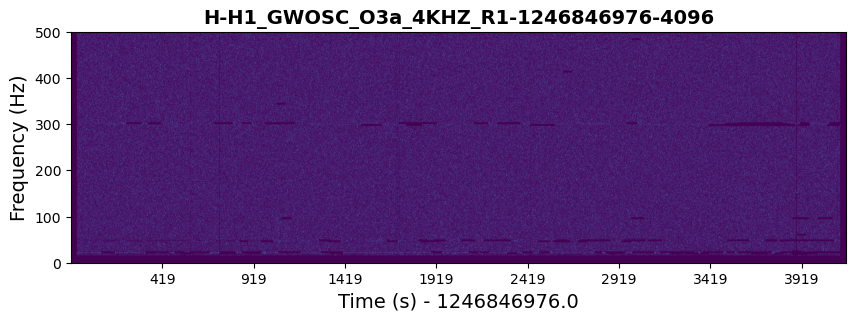

In [17]:
# Optional cell
# Inspect files which were preprocessed if they had issues with triggering

import matplotlib.pyplot as plt
import triggers_single_detector_HM as trig
detector = 'H1'
dname = os.path.join(output_path, f'BBH_{ib}_bank_{0}')
file_ind = 1246846976
fpath = os.path.join(dname, f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trigObj = trig.TriggerList.from_json(fpath)

fig, ax = plt.subplots(figsize=(10,3))
trigObj.specgram(ax=ax);
ax.set_ylim(top=500);

# 2. Coincidence on cluster

In [ ]:
# Maybe run the bulk submission commands in the following on a terminal on your cluster,
# otherwise the outputs from submitting thousands of jobs
# sometimes overload the juptyer notebook

# The cells for checking the file status can be run in the notebook

In [22]:
import os, sys
# Explicitly specify the path to your pipeline folder
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias")
import numpy as np

import template_bank_params_O3a_HM as tbp
import template_bank_generator_HM as tg
import coincidence_HM as coin
import utils
from scipy import stats
import glob

run='O3a'
cand_iter = 'cand2'
trig_dir = utils.TRIG_DIR[f'hm_{run}'.lower()]
cand_dir = utils.CAND_DIR[f'hm_{run}'.lower()]

print('Single det triggers will be used from e.g.,')
print(os.path.join(trig_dir,'BBH_3_bank_1'))
print('Coincident candidates will be saved in e.g.,')
print(os.path.join(cand_dir,f'BBH_3_bank_1{cand_iter}'))

Single det triggers will be used from e.g.,
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Triggers_single_det/BBH_3_bank_1
Coincident candidates will be saved in e.g.,
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Candidates/BBH_3_bank_1cand2


In [ ]:
# Typhon 1st pass
# STATUS: O3b: all done (I just write the status here, e.g., 14-16 done)

ib = 7

submit = True
n_jobs = 5000
# if n_jobs are lower than the number of files,
# each job will be responsible for multiple files
mem_limit = 6

coin_out = []
for ib in [ib]:
    mbkey = f'BBH_{ib}'
    ntemplates = 0
    for isb in range(tbp.nsubbanks[mbkey]):
        bank = tg.TemplateBank.from_json(os.path.join(
            tbp.DIR,mbkey, 'bank_'+str(isb),'metadata.json'))
        ntemplates += bank.ntemplates(tbp.delta_calpha[mbkey], tbp.fudge[mbkey])
    threshold_chi2_veto = np.floor((
        stats.chi2.isf(5/(ntemplates * 180 * 86400 * 1000 * 20), 6) - 7)*6)/6
    print('Threshold_chi2_veto:', max(threshold_chi2_veto,60))
    # For a discussion on threshold_chi2_veto look at the last cell of this section
    
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']): 
        coin_out.append(coin.find_interesting_dir_cluster(
                os.path.join(trig_dir,f'BBH_{ib}_bank_{isb}'),
                output_dir=os.path.join(
                    cand_dir,f'BBH_{ib}_bank_{isb}{cand_iter}'),
                run=run, 
                threshold_chi2=max(threshold_chi2_veto,60),
                job_name=f'C_{ib}_{isb}',
                min_veto_chi2 = max(threshold_chi2_veto/2,30),
                mem_limit=mem_limit,
                submit=submit,
                n_jobs=n_jobs,
                n_hours_limit=24,
                debug=True,
                exclude_nodes=False))

In [ ]:
# Useful example commands to check status on terminal
# squeue -u jayw | grep 'C_9_0'
# squeue -u jayw -t PENDING | wc -l

In [5]:
# Checking .out of the files which failed
# These files will be run again in the next cell
ib = 13
isb = 0

files_failed=[]
dname = os.path.join(cand_dir, f'BBH_{ib}_bank_{isb}{cand_iter}')
for file in glob.glob(os.path.join(dname,'coincident_events_*.out')):
    with open(file, "r") as fobj:
                    contents = fobj.readlines()
                    if len(contents) > 0:
                        if not np.any(['finished' in x for x in contents[-100:]]): files_failed.append(file)

print(f'Num failed: {len(files_failed)}');
# Checking out last few lines of the outputs of files that failed
for i, f in enumerate(files_failed[:50]):
    print('--------- ind:', i)
    !tail -n 5 {f}

Num failed: 0


In [ ]:
# Second pass: 
# O3b: all done (I just write the status here, e.g., 14-16 done)

mem_limit=32 # in GB
n_hours_limit=160

# once a particular bank is complete, see if any coincidence files failed
ib=13

for ib in [ib]:
    mbkey = f'BBH_{ib}'
    bad_files_coin = []
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        json_fname = os.path.join(search_dir+f'Candidates/BBH_{ib}_bank_{isb}{cand_iter}',
                                   'coincidence_parameters_H1_L1.json')
        print(json_fname)
        bad_files_coin.append(coin.restart_run_from_json(json_fname,
            submit=True, debug=False, 
            mem_limit=mem_limit, 
            n_hours_limit=n_hours_limit))
    print(f'Files to redo for bank {ib}: ',[len(x) for x in bad_files_coin])

In [ ]:
# We do vetos during coincidence stage.
# Candidates with SNR above threshold_chi2_veto/2
# are passed through expensive veto tests.
# Due to the cost of these tests,
# we pick a higher threshold at this stage compared to triggering
# (e.g., single detector SNRsq=33)
# Candidates lower than this are directly passed to the next stage
# and rarely appear with a good IFAR
# (but if they do, we specifically pass such outlier low SNR candidates
# through the veto tests in the ranking stage)

# Computation of veto threshold uses the following calculation in
# Gaussian noise

# N indep. "trials" (chances to exceed threshold)   = 
#  180 days * (86400 * 1000) milliseconds per day (autocorrelation length ~1 ms) 
#    * N indep. templates * 20 time delays
# DOF = 6: amplitudes and phases of all three modes
# 5: Number of effective banks we used in the search
# ISF(alpha) threshold s.t. P(trig > threshold | no signal) = alpha
# subtract 7 (est. of V1 chi2) to lower threshold considering Virgo (fishing)

for ib in range(tbp.nbanks):
    mbkey = f'BBH_{ib}'
    ntemplates = 0
    for isb in range(tbp.nsubbanks[mbkey]):
        bank = tg.TemplateBank.from_json(os.path.join(
            tbp.DIR,mbkey,'bank_'+str(isb),'metadata.json'))
        ntemplates += bank.ntemplates(tbp.delta_calpha[mbkey], tbp.fudge[mbkey])
    threshold_chi2_veto = np.floor((
        stats.chi2.isf(5/(ntemplates * 180 * 86400 * 1000 * 20), 6) - 7)*6)/6
    print(f'Bank {ib}: threshold_chi2_veto:', threshold_chi2_veto)

# We use the max of the printed value and 60 (arbitrary convention)

Bank 0: threshold_chi2_veto: 75.33333333333333
Bank 1: threshold_chi2_veto: 71.5
Bank 2: threshold_chi2_veto: 69.5
Bank 3: threshold_chi2_veto: 67.66666666666667
Bank 4: threshold_chi2_veto: 71.66666666666667
Bank 5: threshold_chi2_veto: 67.16666666666667
Bank 6: threshold_chi2_veto: 68.0
Bank 7: threshold_chi2_veto: 66.5
Bank 8: threshold_chi2_veto: 65.0
Bank 9: threshold_chi2_veto: 62.833333333333336
Bank 10: threshold_chi2_veto: 61.333333333333336
Bank 11: threshold_chi2_veto: 60.666666666666664
Bank 12: threshold_chi2_veto: 58.5
Bank 13: threshold_chi2_veto: 59.0
Bank 14: threshold_chi2_veto: 57.5
Bank 15: threshold_chi2_veto: 57.5
Bank 16: threshold_chi2_veto: 57.5


# Extras (please ignore)

In [ ]:
# Please ignore this section
# It just contains some debugging code

In [ ]:
# Alternative way of checking if the "completed files" finished

for file in status[5]:
    with open(dname+\
              f'/{file[-43:-39]}_GWOSC_O3b_4KHZ_R1-{file[-20:-10]}-4096.out', 'r') as f:
        last_line = f.readlines()[-1]
        if (last_line != 'Process finished successfully\n'): print(triggering_on_cluster.filelist(file, dname)[0])

In [ ]:
# For Debugging: running the triggering
# trigObj.processedclist = None
# trigObj.trig_fname = None
# trigObj.nbankchunks_done=0
# trigObj.gen_triggers()

### Downsampling

In [ ]:
# used flag marginalized_score_HM=False in gen_triggers for this section

In [ ]:
filelist_downsampled = np.load('/data/jayw/IAS/GW/Data/Triggers/Downsampled/Filelist.npy')

In [ ]:
# All banks done
# Check njobchunks, mem, fmax

filelist_downsampled = np.load('/data/jayw/IAS/GW/Data/Triggers/Downsampled/Filelist.npy')
run_failed = True

for ib in range(0,1):
    bank_ids = tuple(f'BBH_{i}' for i in range(ib,ib+1)[::-1])
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        bank_subbank_dirs = [[os.path.join('/data/jayw/IAS/GW/Data/Triggers/Downsampled', f'BBH_{ib}_bank_{isb}')]]
        for l in bank_subbank_dirs:
            for dnm in l:
                if not os.path.exists(dnm):
                    os.mkdir(dnm)
        if run_failed:
            status = triggering_on_cluster.inspect_completion(filelist_downsampled, bank_subbank_dirs[0][0])
            filelist_downsampled_use = list(status[2].keys()) #list(status[2].keys()) #status[3]
        else: filelist_downsampled_use = filelist_downsampled.copy()

        # Set fmax (Hz). Default: 1024 for BBH-0 and BBH-1, 512 for rest
        if ibank > 1: fmax=512
        else: fmax=1024
        zz_test = triggering_on_cluster.submit_multibanks(
        use_HM=True, bank_ids=bank_ids, files_to_submit=filelist_downsampled_use,
        cluster="typhon", output_dirs=bank_subbank_dirs, n_cores=1,
        njobchunks=10, # Different for different banks
        mem_per_cpu=16, # 4GB for first pass, then increase to 16-40GB
        fmax=fmax,
        save_hole_correction=True, test_few=None, submit=True)

In [ ]:
dname = f'/data/jayw/IAS/GW/Data/Triggers/Downsampled/BBH_0_bank_4'
status = triggering_on_cluster.inspect_completion(filelist_downsampled, dname);

Reporting run statistics for 268 files
Divided bank into 10 chunks for generating triggers
Didn't start preprocessing for 0 files
Only finished preprocessing for 0 files
Partially generated triggers for 0 files
Failed on 2 files
Couldn't determine fate for 0 files
Finished generating triggers for 266 files


In [ ]:
# All banks done three passes

for ib in range(1,17):
    mbkey = f'BBH_{ib}'
    bad_files_coin = []
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        dire = f'/data/jayw/IAS/GW/Data/Triggers/Downsampled/BBH_{ib}_bank_{isb}cand0'
        json_fname = os.path.join(dire, 'coincidence_parameters_H1_L1.json')
        print(json_fname)
        bad_files_coin.append(coin.restart_run_from_json(json_fname,
            submit=True, debug=False, mem_limit=20, n_hours_limit=160))
    print(f'Files to redo for bank {ib}: ',[len(x) for x in bad_files_coin])

In [ ]:
# all three passes done for comparison upsampled
for ib in range(0,17):
    mbkey = f'BBH_{ib}'
    bad_files_coin = []
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        dire = f'/data/jayw/IAS/GW/Data/Triggers/Downsampled/Comparison_unsampled/BBH_{ib}_bank_{isb}cand0'
        json_fname = os.path.join(dire, 'coincidence_parameters_H1_L1.json')
        print(json_fname)
        bad_files_coin.append(coin.restart_run_from_json(json_fname,
            submit=True, debug=False, mem_limit=32, n_hours_limit=160))
    print(f'Files to redo for bank {ib}: ',[len(x) for x in bad_files_coin])